In [1]:
# ORIGINAL
#import numpy as np
#from xgboost import XGBClassifier
#from sklearn.metrics import balanced_accuracy_score

# OPTIMIZED
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/final-project-group-02

/content/drive/MyDrive/final-project-group-02


In [4]:
!ls

ensemble_model.joblib  scaler.joblib			   xgb_model.joblib
feature_selector.pkl   selector.joblib			   xgb_model.json
kaggle_csv.py	       training_demo_pytorch.ipynb	   Xka.csv
model_bundle.pkl       training_demo_sklearn.ipynb	   Xka_tree.csv
model_tree.json        training_demo_xgboost_040725.ipynb  Xtr.csv
README.md	       training_demo_xgboost_041025.ipynb  Xtr_tree.csv
rf_model.bz2	       training_demo_xgboost_FINAL.ipynb   yka_hat_tree.csv
rf_model.pkl	       training_demo_xgboost.ipynb	   ytr.csv


# training demo for xgboost models

In [5]:
# ORIGINAL
# load training data
Xtr_loadpath = 'Xtr.csv'
Xka_loadpath = 'Xka.csv'
ytr_loadpath = 'ytr.csv'

Xtr = np.loadtxt(Xtr_loadpath, delimiter=",")
Xka = np.loadtxt(Xka_loadpath, delimiter=",")
ytr = np.loadtxt(ytr_loadpath, delimiter=",")

In [6]:
# ORIGINAL
# standardize the training data
#Xtr_standardized = 2.*Xtr # revise this line as needed
#Xka_standardized = 2.*Xka # revise this line as needed

scaler = StandardScaler()
Xtr_standardized = scaler.fit_transform(Xtr)
Xka_standardized = scaler.transform(Xka)

# save the standardized training data
Xtr_savepath = 'Xtr_tree.csv'
Xka_savepath = 'Xka_tree.csv'
yka_hat_savepath = 'yka_hat_tree.csv'

np.savetxt(Xtr_savepath, Xtr_standardized, delimiter=",")
np.savetxt(Xka_savepath, Xka_standardized, delimiter=",")

In [ ]:
# ORIGINAL
# Basic XGBoost - train a model
xg = XGBClassifier(n_estimators=2)
xg.fit(Xtr_standardized, ytr)

acc = balanced_accuracy_score(ytr,xg.predict(Xtr_standardized))
print('training balanced-accuracy: ',acc)

training balanced-accuracy:  0.5293648437098316


In [8]:
# XGBoost
# Randomized search to find the best parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(2, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(xgb, param_dist, scoring='balanced_accuracy', n_iter=30, cv=3, verbose=1)
random_search.fit(Xtr_standardized, ytr)

print("Best parameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': np.float64(0.8262311192472246), 'learning_rate': np.float64(0.3059136319216889), 'max_depth': 7, 'n_estimators': 294, 'subsample': np.float64(0.7366282650451055)}


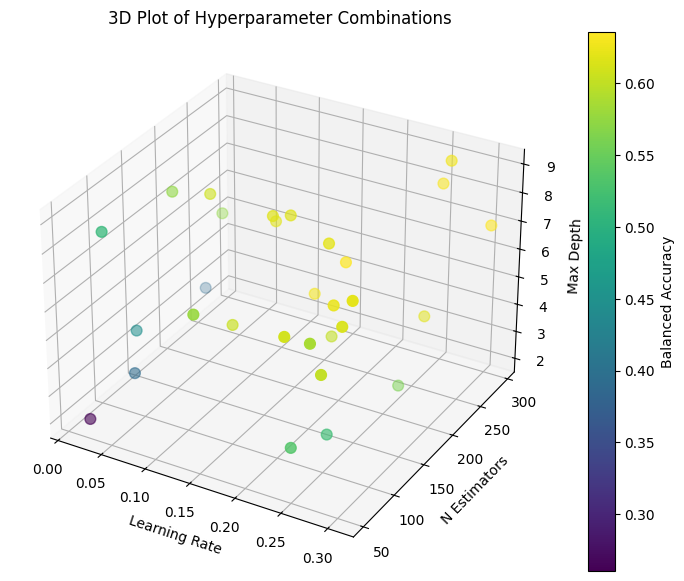

In [13]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    results_df['learning_rate'],
    results_df['n_estimators'],
    results_df['max_depth'],
    c=results_df['mean_test_score'],
    cmap='viridis',
    s=60
)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('N Estimators')
ax.set_zlabel('Max Depth')
fig.colorbar(p, label='Balanced Accuracy')
plt.title('3D Plot of Hyperparameter Combinations')
plt.show()


In [16]:
# XGBoost - Train a model with the best parameter
# Best parameters from RandomizedSearchCV
best_params = {
    'colsample_bytree': 0.8262311192472246,
    'learning_rate': 0.3059136319216889,
    'max_depth': 7,
    'n_estimators': 294,
    'subsample': 0.7366282650451055
}

# Initialize the model with the best parameters
xgb = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    random_state=42
)

# Fit the model to the training data
xgb.fit(Xtr_standardized, ytr)

accb = balanced_accuracy_score(ytr, xgb.predict(Xtr_standardized))
print('training balanced-accuracy: ', accb)

training balanced-accuracy:  1.0


In [ ]:
# Add Feature selection to XGBoost
from sklearn.feature_selection import SelectKBest, f_classif

# Select the top k features (adjust k as needed)
selector = SelectKBest(score_func=f_classif, k=5)  # or k=7, depending on your choice
Xtr_selected = selector.fit_transform(Xtr_standardized, ytr)

# Check which features are selected
selected_features = selector.get_support(indices=True)
print("Selected features:", selected_features)

# Train the model with the selected features
xgb_selected = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    random_state=42
)

xgb_selected.fit(Xtr_selected, ytr)

# Predict and evaluate on the training set
y_pred_train_selected = xgb_selected.predict(Xtr_selected)
acc_train_selected = balanced_accuracy_score(ytr, y_pred_train_selected)
print("Training accuracy with selected features: ", acc_train_selected)

Selected features: [0 2 4 5 8]
Training accuracy with selected features:  0.9998169551365634


In [ ]:
# Random Forest (Basic) - Train a model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Initialize RandomForestClassifier with n_estimators=2 (you can change this if needed)
rf = RandomForestClassifier(n_estimators=2, random_state=42)

# Fit the Random Forest model
rf.fit(Xtr_standardized, ytr)

# Calculate the training balanced accuracy
acc_rf = balanced_accuracy_score(ytr, rf.predict(Xtr_standardized))

# Print the training balanced accuracy
print('Training balanced accuracy: ', acc_rf)


Training balanced accuracy:  0.7577791509883235


In [14]:
# Find the best parameter for Random forest - RandomizedsearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier

# Define the parameter distribution for RandomForestClassifier
param_dist = {
    'n_estimators': randint(50, 300),  # Number of trees in the forest
    'max_depth': randint(2, 12),  # Maximum depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV to find the best hyperparameters
random_search_rf = RandomizedSearchCV(rf, param_dist, scoring='balanced_accuracy', n_iter=30, cv=3, verbose=1)

# Fit the RandomizedSearchCV
random_search_rf.fit(Xtr_standardized, ytr)

# Print the best parameters found
print("Best parameters:", random_search_rf.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'bootstrap': False, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 279}


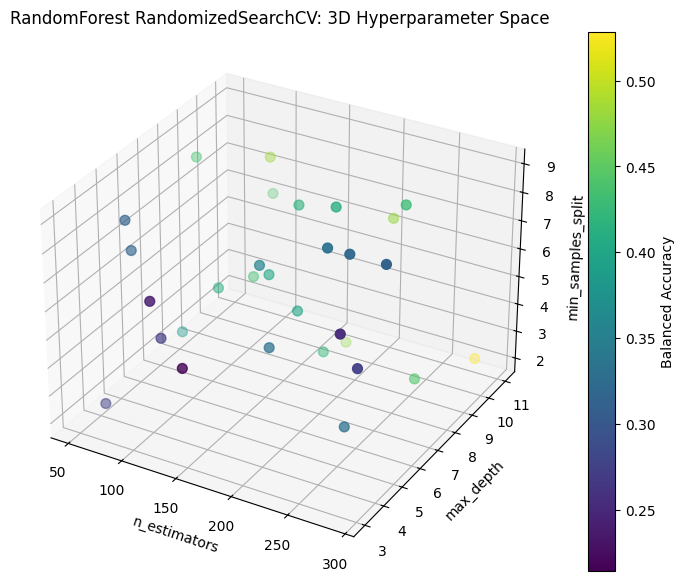

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert the search results to a DataFrame
results_rf = random_search_rf.cv_results_
rf_results_df = pd.DataFrame(results_rf['params'])
rf_results_df['mean_test_score'] = results_rf['mean_test_score']

# Create a 3D scatter plot using three numeric hyperparameters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = rf_results_df['n_estimators']
y = rf_results_df['max_depth']
z = rf_results_df['min_samples_split']
c = rf_results_df['mean_test_score']

scatter = ax.scatter(x, y, z, c=c, cmap='viridis', s=50)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('min_samples_split')
fig.colorbar(scatter, label='Balanced Accuracy')
ax.set_title("RandomForest RandomizedSearchCV: 3D Hyperparameter Space")

plt.show()

In [17]:
# Best parameter Random Forest
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

# Apply the best hyperparameters found
rfb = RandomForestClassifier(
    bootstrap=False,  # From the best params
    max_depth=11,  # From the best params
    max_features='sqrt',  # From the best params
    min_samples_leaf=2,  # From the best params
    min_samples_split=2,  # From the best params
    n_estimators=279,  # From the best params
    random_state=42
)

# Fit the Random Forest model to the training data
rfb.fit(Xtr_standardized, ytr)

# Calculate the training balanced accuracy
accb_rf = balanced_accuracy_score(ytr, rfb.predict(Xtr_standardized))

# Print the training balanced accuracy
print('Training balanced accuracy: ', accb_rf)

Training balanced accuracy:  0.7359712002883146


In [18]:
# Random forest method with feature selection

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel

# Use SelectFromModel to select important features
selector = SelectFromModel(rfb, threshold="mean", max_features=5)  # "mean" threshold to select features above average importance
X_selected = selector.transform(Xtr_standardized)  # Transform the training data to selected features

# Train a new model using the selected features
best_rf_selected = RandomForestClassifier(
    bootstrap=False,  # Same as before
    max_depth=11,  # Same as before
    max_features='sqrt',  # Same as before
    min_samples_leaf=2,  # Same as before
    min_samples_split=2,  # Same as before
    n_estimators=279,  # Same as before
    random_state=42
)

# Fit the new Random Forest model with selected features
best_rf_selected.fit(X_selected, ytr)

# Make predictions on the selected features
y_pred_train_rf_selected = best_rf_selected.predict(X_selected)

# Calculate the training balanced accuracy
accb_rf_selected = balanced_accuracy_score(ytr, y_pred_train_rf_selected)

# Print the training balanced accuracy for the model with selected features
print("Training balanced accuracy (RF with feature selection):", accb_rf_selected)

Training balanced accuracy (RF with feature selection): 0.5136210869517531


In [ ]:
# Ensemble method using Random forest and XGBoost (Trial)

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score

# Create individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Combine models into a VotingClassifier (soft voting)
ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(Xtr_standardized, ytr)

# Make predictions
y_pred = ensemble_model.predict(Xtr_standardized)

# Calculate balanced accuracy
acc = balanced_accuracy_score(ytr, y_pred)
print("Training balanced accuracy (Voting Classifier):", acc)


Training balanced accuracy (Voting Classifier): 0.9991906518077508


In [19]:
# save the model: you must use the .json format for xgboost models!
model_savepath = 'model_tree.json'
#xg.save_model(model_savepath)
xgb.save_model(model_savepath)

In [20]:
# ORIGINAL
# generate kaggle submission file using the validation script
!python {"kaggle_csv.py " + model_savepath + " --Xka_path " + Xka_savepath + " --Xtr_path " + Xtr_savepath + " --yka_hat_path " + yka_hat_savepath }

training balanced-accuracy =  1.0
kaggle label predictions saved in yka_hat_tree.csv


In [ ]:
# another way to generate kaggle submission file using the validation script
%run {"kaggle_csv.py " + model_savepath + " --Xka_path " + Xka_savepath + " --Xtr_path " + Xtr_savepath + " --yka_hat_path " + yka_hat_savepath }